###A Machine and Deep Learning Framework to Retain Customers based on their Lifetime Value

####Kannan Kumaran (ID:x20195061)

In [1]:
# Importing necessary libraries
from dateutil import parser
import datetime
from dateutil import relativedelta

!pip install openpyxl
!pip install squarify
!pip install KMeans
!pip install Lifetimes
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import squarify  # treemap 
import warnings 
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score






from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree



  Created wheel for KMeans: filename=kmeans-1.0.2-cp37-cp37m-linux_x86_64.whl size=11792 sha256=75e9734c701d94f9b9d01e6b1ac862d069ec24d1eba8381fa73d32d08249448a
  Stored in directory: /root/.cache/pip/wheels/4a/26/51/688c6987fdc6a10c6186c3817f2ef7c92c50c078a900525c0e
Successfully built KMeans
     |████████████████████████████████| 584 kB 5.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [3]:
# Reading the excel format data set by using "Year 2010-2011" sheet named.
#The data set should be uploaded in the drive of colab

df= pd.read_excel("drive/My Drive/Online Retail/online_retail_II.xlsx", sheet_name = "Year 2010-2011")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape 

(541910, 8)

# Data pre-processing 

In [5]:
df.isna().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [6]:
# Define function to find missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Customer ID,135080,24.9
Description,1454,0.3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# Step 1 of Data Preparation: Eliminating null oberservations, duplictaes and cancelled orders
df.dropna(inplace=True)
# Drop duplicate data
df.drop_duplicates(inplace=True)

df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,392733.0,13.153687,181.588189,1.0,1.00,2.00,6.00,12.00,120.00,80995.00
Price,392733.0,3.125633,22.240710,0.0,0.21,1.25,1.95,3.75,14.95,8142.75
Customer ID,392733.0,15287.728182,1713.570644,12346.0,12415.00,13955.00,15150.00,16791.00,18211.00,18287.00


In [11]:
# Defining functions for outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Defining functions to replace outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [12]:
# Step 2 of Data Preparation: Replacing outliers in the Quantity and Price columns with the upper limit
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,392733.0,11.953142,25.665462,1.0,1.00,2.00,6.00,12.00,120.00,298.50
Price,392733.0,2.899674,3.237673,0.0,0.21,1.25,1.95,3.75,14.95,37.06
Customer ID,392733.0,15287.728182,1713.570644,12346.0,12415.00,13955.00,15150.00,16791.00,18211.00,18287.00


In [13]:
# Step 3 of Data Preparation: Calculating total price per transaction 
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)
# Defining today date as max(InvoiceDate) + 2 days
today_date = dt.datetime(2011, 12, 11)
print(f" Maximum invoice date: {df.InvoiceDate.max()} \n Today date: {today_date}")
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

act_date = max(df['InvoiceDay'] + dt.timedelta(1))

 Maximum invoice date: 2011-12-09 12:50:00 
 Today date: 2011-12-11 00:00:00


In [14]:
df.shape

(392733, 10)

### Preliminary visualisations before prediction of customer lifetime value

                      Country      Ratio
United Kingdom         349227  88.922245
Germany                  9027   2.298508
France                   8328   2.120525
EIRE                     7228   1.840436
Spain                    2480   0.631472
Netherlands              2363   0.601681
Belgium                  2031   0.517145
Switzerland              1842   0.469021
Portugal                 1453   0.369971
Australia                1184   0.301477
Norway                   1072   0.272959
Italy                     758   0.193006
Channel Islands           747   0.190206
Finland                   685   0.174419
Cyprus                    603   0.153539
Sweden                    450   0.114582
Austria                   398   0.101341
Denmark                   380   0.096758
Poland                    330   0.084027
Japan                     321   0.081735
Israel                    245   0.062383
Unspecified               241   0.061365
Singapore                 222   0.056527
Iceland         

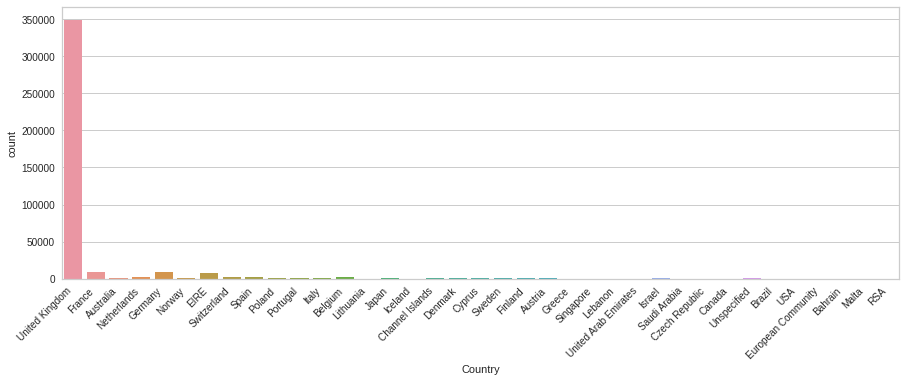

In [15]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
   
    if plot:
        fig_dims = (15, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()

cat_summary(df, "Country", plot=True)

In [16]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12-09


In [17]:
online_retail = df

In [18]:
# Calculating count of top 10 countries
top_ten_countries = online_retail['Country'].value_counts()
top_ten_countries = top_ten_countries.iloc[0:11]

Text(0, 0.5, 'Purchase count')

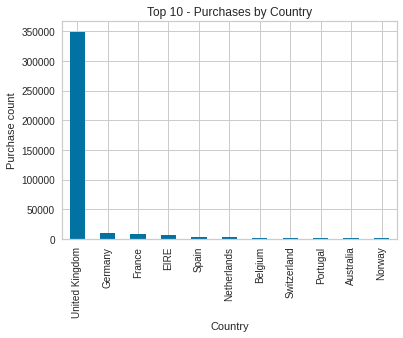

In [19]:
# Bar plot visualization of top 10 countries with respect to purchase count
top_ten_countries.plot(kind='bar', title = 'Top 10 - Purchases by Country')
plt.xlabel("Country")
plt.ylabel("Purchase count")

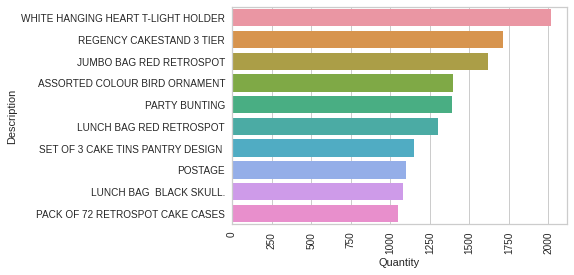

In [20]:
df_product = df.groupby("Description").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product


top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)

sns.barplot(y="Description", x="Quantity", data=top_pr)
plt.xticks(rotation=90)
plt.show()

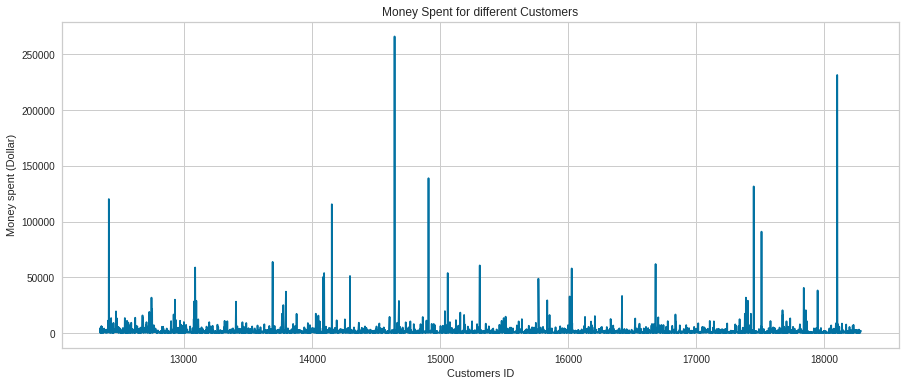

In [21]:
money_spent = df.groupby(by=['Customer ID','Country'], as_index=False)['TotalPrice'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent["Customer ID"], money_spent.TotalPrice)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

In [22]:
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='TotalPrice', ascending=False).head()

The TOP 5 customers with highest money spent...


,Customer ID,Country,TotalPrice
1698,14646.0,Netherlands,266163.525
4210,18102.0,United Kingdom,231584.345
1888,14911.0,EIRE,138919.840
3737,17450.0,United Kingdom,131550.645
57,12415.0,Australia,120210.355


count    392733.000000
mean         11.953142
std          25.665462
min           1.000000
5%            1.000000
10%           1.000000
20%           2.000000
30%           2.000000
40%           4.000000
50%           6.000000
60%           8.000000
70%          12.000000
80%          12.000000
90%          24.000000
95%          36.000000
99%         120.000000
max         298.500000
Name: Quantity, dtype: float64


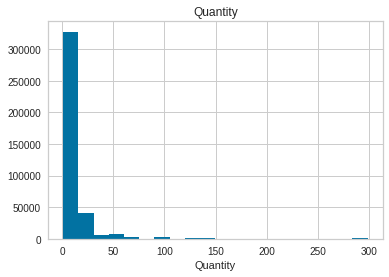

count                  392733
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object


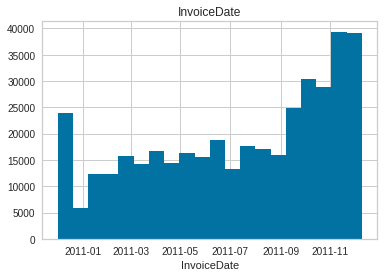

count    392733.000000
mean          2.899674
std           3.237673
min           0.000000
5%            0.420000
10%           0.550000
20%           0.850000
30%           1.250000
40%           1.650000
50%           1.950000
60%           2.100000
70%           2.950000
80%           4.150000
90%           6.350000
95%           8.500000
99%          14.950000
max          37.060000
Name: Price, dtype: float64


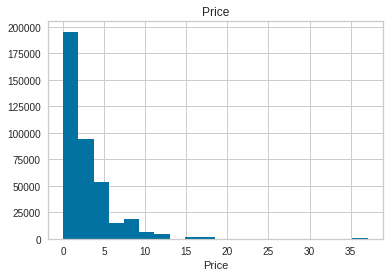

count    392733.000000
mean         20.839392
std          52.127126
min           0.000000
5%            1.250000
10%           2.080000
20%           3.750000
30%           5.900000
40%           8.850000
50%          12.390000
60%          15.000000
70%          17.400000
80%          20.800000
90%          35.400000
95%          67.500000
99%         187.500000
max        3268.575000
Name: TotalPrice, dtype: float64


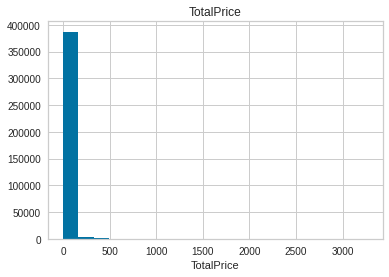

count                  392733
unique                    305
top       2011-11-06 00:00:00
freq                     3340
first     2010-12-01 00:00:00
last      2011-12-09 00:00:00
Name: InvoiceDay, dtype: object


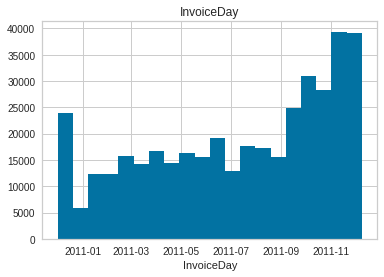

In [23]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Customer ID"]
num_cols
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)


In [24]:
df_new=df.copy()
df_new.rename(index=str, columns={'Invoice': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'Price' : 'unit_price',
                              'Customer ID' : 'cust_id',
                              'TotalPrice' : 'amount_spent',
                              'Country' : 'country'}, inplace=True)

In [25]:
df_new = df_new[['invoice_num','invoice_date','stock_code','description','quantity','unit_price','amount_spent','cust_id','country']]

In [26]:
df_new.insert(loc=2, column='year_month', value=df_new['invoice_date'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.invoice_date.dt.month)

df_new.insert(loc=4, column='day', value=(df_new.invoice_date.dt.dayofweek)+1)
df_new.insert(loc=5, column='hour', value=df_new.invoice_date.dt.hour)

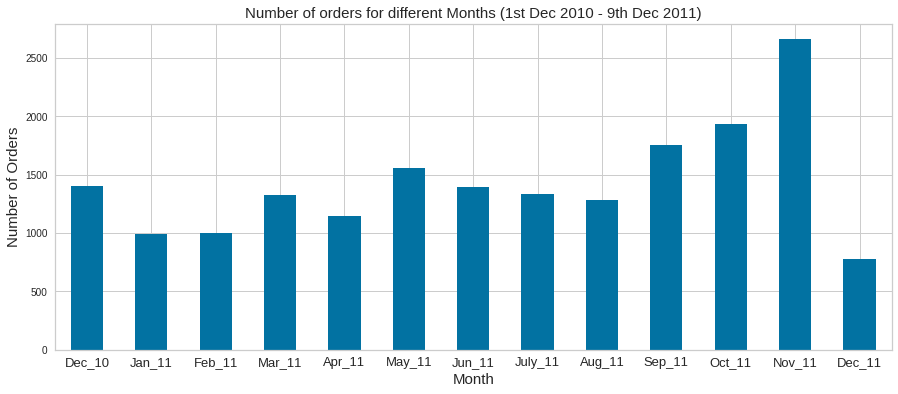

In [27]:
# Number of orders in different months
color = sns.color_palette()
ax = df_new.groupby('invoice_num')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

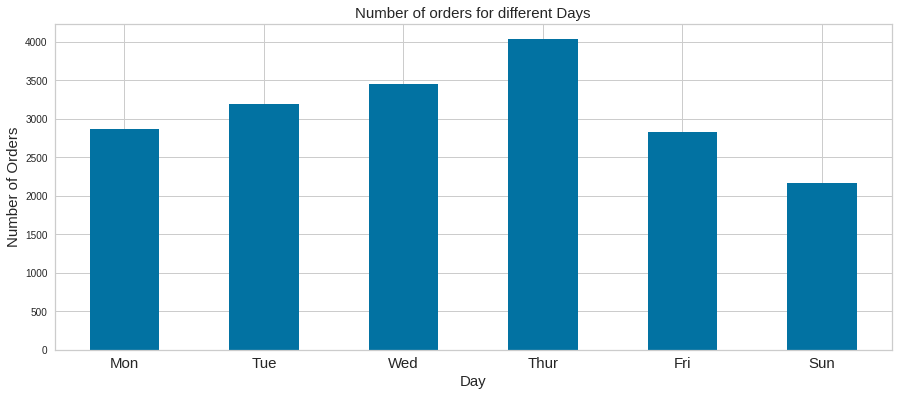

In [28]:
# Number of orders in a day
ax = df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

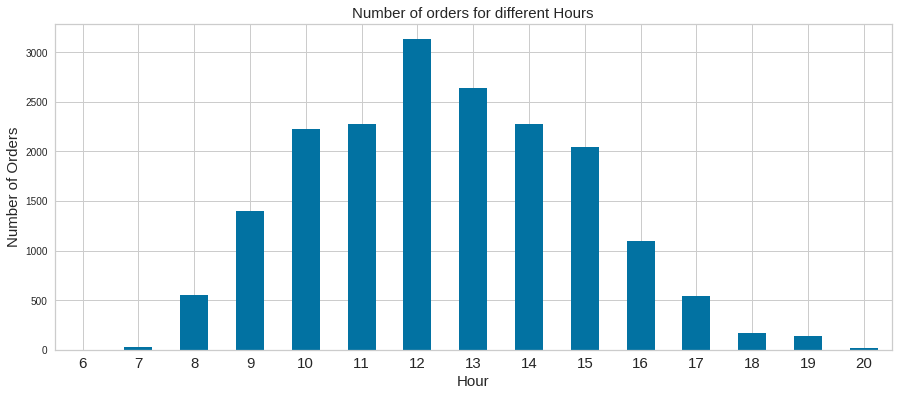

In [29]:
# Number of orders in an hour
ax = df_new.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

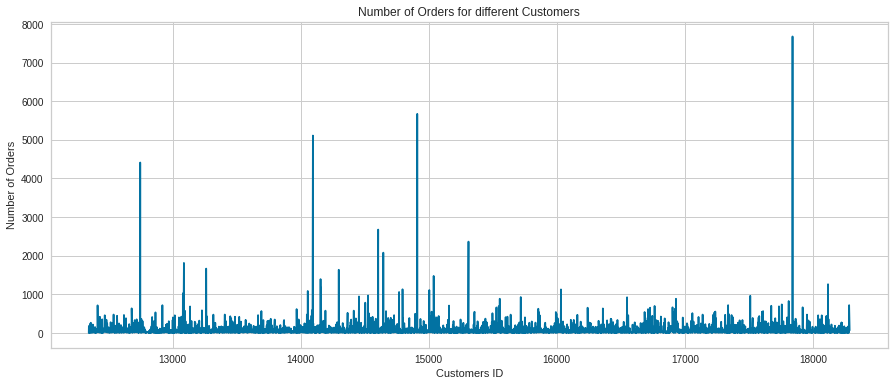

The TOP 5 customers with most number of orders...


,cust_id,country,invoice_num
4019,17841.0,United Kingdom,7676
1888,14911.0,EIRE,5672
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4413
1670,14606.0,United Kingdom,2677


In [30]:
# Top 5 most orders
orders = df_new.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.cust_id, orders.invoice_num)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()
print('The TOP 5 customers with most number of orders...')
orders.sort_values(by='invoice_num', ascending=False).head()



*   The inferences from exploratory data analysis are customers that has placed the most orders are from the United Kingdom 
*   Customers that spends the most price on purchases is from the Netherlands. 
*   Product in demand was “White Hanging T-light Holder”
*  The month of November in year 2011 had the highest sales. According to days of week, Monday to Thursday faced a steady increase and later decreases.

In [31]:
# Remove days from December 2011
online_retail = online_retail[online_retail.InvoiceDate < '2011-12-01']

In [32]:
# Remove rows were Unit price is 0.0
online_retail = online_retail[online_retail['Price'] !=0.0]

In [33]:
# renaming the attribute
online_retail.rename(columns = {"TotalSum": "total_sales_amount"},  
          inplace = True) 

## RMF Implementation

In [34]:
# Creation of RFM parameters
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (act_date - x.max()).days,
    'Invoice' : 'count',
    'TotalPrice' : 'sum'
})

rfm.rename(columns = {'InvoiceDate' : 'Recency', 
                      'Invoice' : 'Frequency', 
                      'TotalPrice' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,1,310.44
12347.0,2,182,4310.00
12348.0,75,31,1770.78
12349.0,18,73,1491.72
12350.0,310,17,331.46


In [35]:
# Splitting into quartiles
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels)

f_labels = range(1, 4)
f_groups = pd.qcut(rfm.Frequency, q = 3, labels = f_labels)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.Monetary, q = 3, labels = m_labels)

In [36]:
# Calculation of RFM score
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

rfm = rfm.assign(R=r_groups,F=f_groups,M=m_groups)


rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer ID,,,,,,,
12346.0,325,1,310.44,1,1,1,3
12347.0,2,182,4310.00,3,3,3,9
12348.0,75,31,1770.78,2,2,3,7
12349.0,18,73,1491.72,3,3,3,9
12350.0,310,17,331.46,1,1,1,3


In [37]:
# Displaying the mean of RFM parameters
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})

rfm_agg.rename(columns = {'mean' : 'Mean','count' : 'Count'},
               inplace = True)

rfm_agg.round(2).head()

Recency Frequency Monetary      
             Mean      Mean     Mean Count
RFM_Score                                 
3          236.83     10.44   197.29   644
4          136.52     18.86   305.43   561
5          109.75     29.33   542.33   701
6           65.95     46.99   789.26   605
7           48.96     73.44  1269.35   563

In [38]:
# Formation of groups using RFM scores
score_labels = ['Low', 'Medium', 'High']
score_groups = pd.qcut(rfm.RFM_Score, q = 3, labels = score_labels)
rfm['Robust RFM Level'] = score_groups.values

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level
Customer ID,,,,,,,,
12346.0,325,1,310.44,1,1,1,3,Low
12347.0,2,182,4310.00,3,3,3,9,High
12348.0,75,31,1770.78,2,2,3,7,Medium
12349.0,18,73,1491.72,3,3,3,9,High
12350.0,310,17,331.46,1,1,1,3,Low


In [39]:
rfm.describe()

,Recency,Frequency,Monetary,RFM_Score
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,92.041484,90.512330,1886.221900,6.007605
std,100.007757,225.515289,7701.122165,2.027857
min,0.000000,1.000000,0.000000,3.000000
25%,17.000000,17.000000,302.050000,4.000000
50%,50.000000,41.000000,657.230000,6.000000
75%,141.500000,98.000000,1625.090000,8.000000
max,373.000000,7676.000000,266163.525000,9.000000


In [40]:
# Only positive purchases (No cancelations)
online_retail_purchases = online_retail

In [41]:
# Chossing the needed parameters for prediction of CLV
transactional_purchases = (
    online_retail_purchases.groupby(["Invoice", "Customer ID", "InvoiceDate"])[
        ["Quantity", "TotalPrice"]
    ]
    .agg("sum")
    .reset_index()
)

In [42]:
transactional_purchases.head()

,Invoice,Customer ID,InvoiceDate,Quantity,TotalPrice
0,536365,17850.0,2010-12-01 08:26:00,40.0,139.12
1,536366,17850.0,2010-12-01 08:28:00,12.0,22.20
2,536367,13047.0,2010-12-01 08:34:00,83.0,278.73
3,536368,13047.0,2010-12-01 08:34:00,15.0,70.05
4,536369,13047.0,2010-12-01 08:35:00,3.0,17.85


In [43]:
# Configurable experimental variables 
SPLIT_DATE = "2011-08-01" # Date to be used to end train date
PERIOD_LENGTH = 2 # Months

In [44]:
# Split of train and test dataset
date = parser.parse(SPLIT_DATE)
end_date = date + relativedelta.relativedelta(months=2)
end_test_date = end_date.strftime("%Y-%m-%d")

train = transactional_purchases[transactional_purchases["InvoiceDate"] < SPLIT_DATE]
test = transactional_purchases[
    (transactional_purchases["InvoiceDate"] >= SPLIT_DATE)
    & (transactional_purchases["InvoiceDate"] < end_test_date)
]

print("Start Train dataset date {}".format(train["InvoiceDate"].min()))
print("End Train dataset date {}".format(train["InvoiceDate"].max()))
print("---------------------------------------------")
print("Start Test dataset date {}".format(test["InvoiceDate"].min()))
print("End Test dataset date {}".format(test["InvoiceDate"].max()))

Start Train dataset date 2010-12-01 08:26:00
End Train dataset date 2011-07-31 16:04:00
---------------------------------------------
Start Test dataset date 2011-08-01 08:30:00
End Test dataset date 2011-09-30 15:52:00


In [45]:
# Create Features (Frequency, Recency and T) for customers
features_train = summary_data_from_transaction_data(
    train,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    freq="D",
)
features_train.reset_index(level=0, inplace=True)

In [46]:
features_train


,Customer ID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,194.0,0.000000
1,12347.0,3.0,184.0,236.0,498.053333
2,12348.0,2.0,110.0,227.0,294.280000
3,12350.0,0.0,0.0,179.0,0.000000
4,12352.0,3.0,34.0,165.0,176.770000
...,...,...,...,...,...
3143,18273.0,0.0,0.0,126.0,0.000000
3144,18280.0,0.0,0.0,146.0,0.000000
3145,18281.0,0.0,0.0,49.0,0.000000
3146,18283.0,7.0,189.0,206.0,120.497143



## Beta geometric / Negative binomial distribution model implementation

In [47]:
# Fit to the BG/NBD model 
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(features_train['frequency'], features_train['recency'], features_train['T']) 
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 3148 subjects, a: 0.00, alpha: 46.00, b: 0.00, r: 0.53>


In [48]:
customers = features_train[['Customer ID']]

In [49]:
# Predict future total amount spent for individual customers (next period)
t = PERIOD_LENGTH*30  # Days (2 Months aprox)
customers["pred_n_purchases"] = bgf.predict(
    t, features_train["frequency"], features_train["recency"], features_train["T"]
)

### Prediction of future purchases using BG/NBD model

In [50]:
# Storing actual and predicted values in a seperate dataframe
y_predictions = customers[["Customer ID", "pred_n_purchases"]]

test_n_purchases = (
    test["Customer ID"]
    .value_counts()
    .rename_axis("Customer ID")
    .to_frame("true_n_purchases")
)

dataset = pd.merge(y_predictions, test_n_purchases, on='Customer ID', how='left')
dataset['true_n_purchases'].fillna(0, inplace= True) # No sales 

In [51]:
y_true_n_purchases = dataset['true_n_purchases']
y_pred_n_purchases = dataset['pred_n_purchases']

### Evaluation of BG/NBD model

In [52]:
mean_squared_error(y_true_n_purchases, y_pred_n_purchases, squared=False)

1.1395401549616673

In [53]:

mae = mean_absolute_error(y_true_n_purchases, y_pred_n_purchases)
mse = mean_squared_error(y_true_n_purchases, y_pred_n_purchases)
r2 = r2_score(y_true_n_purchases, y_pred_n_purchases)

print('Mean absolute error: ', mae)
print('Mean squared error:', mse)
print('r2 score:', r2)

Mean absolute error:  0.663510127986334
Mean squared error: 1.2985517647700608
r2 score: 0.5199797209041828


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


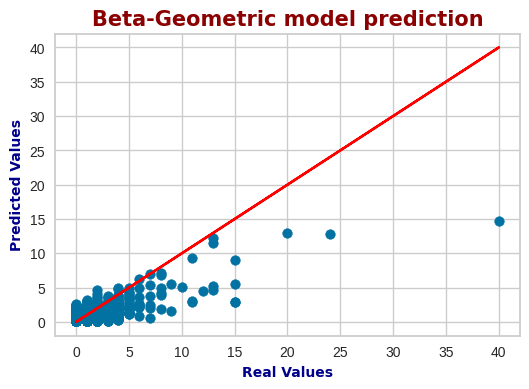

In [54]:
# Visualization of predicted and actual values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_true_n_purchases, y_pred_n_purchases)
plt.plot(y_true_n_purchases, y_true_n_purchases, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Beta-Geometric model prediction", fontdict=baslik_font)
plt.show()

In [55]:
# Storing the evaluation results in a dataframe
Bg = pd.DataFrame({'algorithm':['BG/NBD'],
            'MSE': [mean_squared_error(y_true_n_purchases, y_pred_n_purchases)],
            'MAE': [mean_absolute_error(y_true_n_purchases, y_pred_n_purchases)],
            'r2_score': [r2_score(y_true_n_purchases, y_pred_n_purchases)],})
Bg

,algorithm,MSE,MAE,r2_score
0,BG/NBD,1.298552,0.66351,0.51998


## Gamma Gamma model implementation

In [56]:
# Amount spent by customer current period
test_amount_spent = (
    test.groupby(["Customer ID"])[["TotalPrice"]]
    .agg("sum")
    .reset_index()
    .rename(columns={"TotalPrice": "true_amount_spent_next_period"})
)

In [57]:
# In order to fit model remove the items that have 0 as monetary value
f_r_t_summary2 = features_train[features_train['monetary_value']>0]

In [58]:
# Correlation between variables

ext_corre1 = features_train[['frequency', 'monetary_value']]
ext_corre1 = ext_corre1.corr()
ext_corre1

,frequency,monetary_value
frequency,1.000000,0.315885
monetary_value,0.315885,1.000000


In [59]:
# Fit GammaGamma model 
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(f_r_t_summary2['frequency'],
        f_r_t_summary2['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1745 subjects, p: 2.43, q: 3.43, v: 399.21>


Prediction of future amount spent using gamma-gamma model

In [60]:
f_r_t_summary2["pred_amount_spent_next_period"] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    f_r_t_summary2['frequency'],
    f_r_t_summary2['recency'],
    f_r_t_summary2['T'],
    f_r_t_summary2['monetary_value'],
    time=PERIOD_LENGTH, # months
    discount_rate=0.01 # monthly discount rate
)

In [61]:
y_predictions = f_r_t_summary2[["Customer ID", "pred_amount_spent_next_period"]] 

In [62]:
# Storing the true and predicted amount in a seperate dataframe
dataset = pd.merge(customers['Customer ID'], y_predictions, on='Customer ID', how='left')
dataset = pd.merge(dataset, test_amount_spent, on='Customer ID', how='left')
dataset['pred_amount_spent_next_period'].fillna(0, inplace= True) # Fill No sales with 0
dataset['true_amount_spent_next_period'].fillna(0, inplace= True) # Fill No sales with 0

In [63]:
dataset

,Customer ID,pred_amount_spent_next_period,true_amount_spent_next_period
0,12346.0,0.000000,0.00
1,12347.0,349.700694,584.91
2,12348.0,179.985883,307.06
3,12350.0,0.000000,0.00
4,12352.0,229.448537,623.68
...,...,...,...
3143,18273.0,0.000000,102.00
3144,18280.0,0.000000,0.00
3145,18281.0,0.000000,0.00
3146,18283.0,274.165205,134.90


In [64]:
y_true_amount_spent = dataset['true_amount_spent_next_period']
y_pred_amount_spent = dataset['pred_amount_spent_next_period']

### Evaluation of Gamma Gamma model

In [65]:
mae = mean_absolute_error(y_true_amount_spent, y_pred_amount_spent)
mse = mean_squared_error(y_true_amount_spent, y_pred_amount_spent)
r2 = r2_score(y_true_amount_spent, y_pred_amount_spent)

print('Mean absolute error: ', mae)
print('Mean squared error:', mse)
print('r2 score:', r2)

Mean absolute error:  300.5809999702518
Mean squared error: 1885670.6694622342
r2 score: 0.5714622637755268


In [66]:
# Storing evaluation results in a seperate dataframe
Gamma_Gamma = pd.DataFrame({'algorithm':['Gamma-Gamma'],
            'MSE': [mean_squared_error(y_true_amount_spent, y_pred_amount_spent)],
            'MAE': [mean_absolute_error(y_true_amount_spent, y_pred_amount_spent)],
            'r2_score': [r2_score(y_true_amount_spent, y_pred_amount_spent)],})
Gamma_Gamma

,algorithm,MSE,MAE,r2_score
0,Gamma-Gamma,1.885671e+06,300.581,0.571462


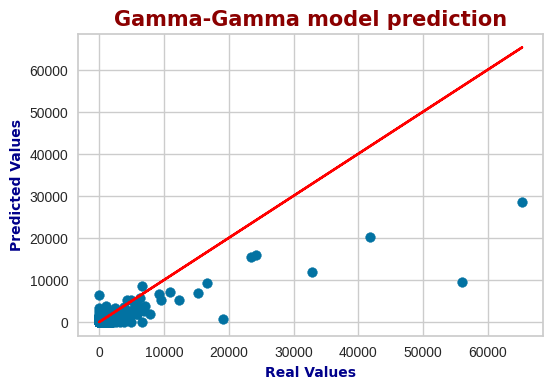

In [67]:
# Visualization of real and predicted values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_true_amount_spent, y_pred_amount_spent)
plt.plot(y_true_amount_spent, y_true_amount_spent, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Gamma-Gamma model prediction", fontdict=baslik_font)
plt.show()

## CLV prediction using Machine and Deep Learning algorithms

## Deep Neural Network

In [68]:
#Get revenue column
df['Revenue'] = df['Quantity'] * df['Price']

#Context df for the revenue (date & customerID)
id_lookup = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()
id_lookup.index = id_lookup['Invoice']
id_lookup = id_lookup.drop('Invoice', axis=1)

transactions_df = pd.DataFrame(df.groupby('Invoice')['Revenue'].sum()).join(id_lookup)

In [69]:
#Spit into train - test
rfm_train_test = calibration_and_holdout_data(transactions_df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-09-10',
                                        monetary_value_col = 'Revenue')   

#Selecting only customers with positive value in the calibration period (otherwise Gamma-Gamma model doesn't work)
rfm_train_test = rfm_train_test.loc[rfm_train_test['monetary_value_cal'] > 0, :]

       Invoice StockCode  ... weekend  dayofweek
533498  581027     22411  ...   False          2
156004  550035     21928  ...   False          3
337175  566434     22766  ...   False          0
63100   541520     20728  ...   False          2
412308  572284     22138  ...    True          6

[5 rows x 16 columns]
373 days 00:00:00


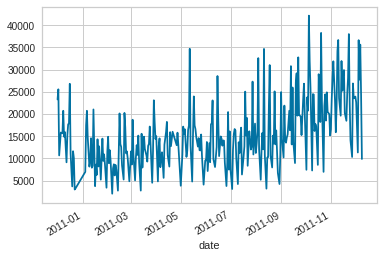

In [70]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format = '%d/%m/%Y %H:%M')
#Datetime transformation
df['date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['time'] = df.InvoiceDate.dt.time
df['hour'] = df['time'].apply(lambda x: x.hour)
df['weekend'] = df['date'].apply(lambda x: x.weekday() in [5, 6])
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
#Get revenue column
df['Revenue'] = df['Quantity'] * df['Price']

print(df.sample(5))

#Plots a timeseries of total sales
df.groupby('date')['Quantity'].sum().plot()
#Prints the total number of days between start and end
print(df['date'].max() - df['date'].min())

In [71]:
def get_features(df, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * df - a dfframe with raw df
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    #Double check the periods length
    features_df = df.loc[(df.date >= feature_start) & (df.date <= feature_end), :]
    print(f'Using df from {(pd.Timestamp(feature_end) - pd.Timestamp(feature_start)).days} days')
    print(f'To predict {(pd.Timestamp(target_end) - pd.Timestamp(target_start)).days} days')
    
    #Transactions df features
    total_rev = features_df.groupby('Customer ID')['Revenue'].sum().rename('total_revenue')
    recency = (features_df.groupby('Customer ID')['InvoiceDate'].max() - features_df.groupby('Customer ID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_df.groupby('Customer ID')['Invoice'].count().rename('frequency')
    t = features_df.groupby('Customer ID')['date'].min().apply(lambda x: (pd.Timestamp(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_df.groupby('Customer ID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_df.loc[features_df['Revenue'] < 0, :].groupby('Customer ID')['Invoice'].count().rename('num_returns')
    hour = features_df.groupby('Customer ID')['hour'].median().rename('purchase_hour_med')
    dow = features_df.groupby('Customer ID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_df.groupby('Customer ID')['weekend'].mean().rename('purchase_weekend_prop')
    train_df = pd.DataFrame(index = rfm_train_test.index)
    train_df = train_df.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_df = train_df.fillna(0)
    
    #Target df
    target_df = df.loc[(df.date >= target_start) & (df.date <= target_end), :]
    target_quant = target_df.groupby(['Customer ID'])['date'].nunique()
    target_rev = target_df.groupby(['Customer ID'])['Revenue'].sum().rename('target_rev')
    train_df = train_df.join(target_rev).fillna(0)
    
    return train_df.iloc[:, :-1], train_df.iloc[:, -1] #X and Y


#Dates are taken from the discussion above
X_train, y_train = get_features(df, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')
X_test, y_test = get_features(df, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')

print(X_train.head())

Using df from 161 days
To predict 89 days
Using df from 161 days
To predict 89 days
             total_revenue  recency  ...  purchase_dow_med  purchase_weekend_prop
Customer ID                          ...                                         
12347.0            1494.16    134.0  ...               3.0                    0.0
12348.0             588.56     70.0  ...               1.0                    0.0
12352.0             826.81     34.0  ...               2.0                    0.0
12356.0            2753.08     80.0  ...               1.0                    0.0
12359.0            2928.09    142.0  ...               0.0                    0.0

[5 rows x 11 columns]


In [72]:
#Deep Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
    
    return model

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=30)

model = build_model()
#Should take 10 sec
early_history = model.fit(X_train, y_train, 
                    epochs=5, batch_size=32, verbose=0, 
                    callbacks=[early_stop])



Total Sales Actual: 2216485.0
Total Sales Predicted: 2214208.0
Individual R2 score: 0.7154442000422669 
Individual Mean Absolute Error: 747.7075455846102
Individual Mean Squared Error: 2438.5997454265976


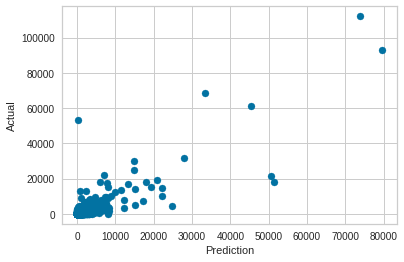

In [73]:
# Evaluation of DNN
def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    print(f"Individual Mean Squared Error: { mean_squared_error(actual, sales_prediction)**(1/2)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()

#Predicting
dnn_preds = model.predict(X_test).ravel()

evaluate(y_test, dnn_preds)

In [74]:
# storing results in a dataframe
DNN_results = pd.DataFrame({'algorithm':['Deep Neural Network'],
            'MSE': [mean_squared_error(y_test, dnn_preds)],
            'MAE': [mean_absolute_error(y_test, dnn_preds)],
            'r2_score': [r2_score(y_test, dnn_preds)],})
DNN_results

,algorithm,MSE,MAE,r2_score
0,Deep Neural Network,5.946769e+06,747.707546,0.715444


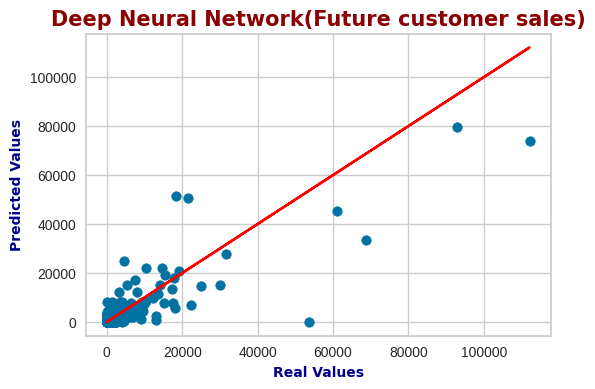

In [75]:
# Visualization of preidcted and real values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, dnn_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Deep Neural Network(Future customer sales)", fontdict=baslik_font)
plt.show()

### Linear Regression

In [76]:
#Linear Regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
# Train and predict the model
LR = LinearRegression()
LR.fit(X_train, y_train)

y_pred_score = LR.score(X_test, y_test)
print("Prediction score is: {}".format(y_pred_score))

y_pred_l = LR.predict(X_test)

Prediction score is: 0.6892344272124986


In [77]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
print('RMSE: ', mean_squared_error(y_test, y_pred_l)**(1/2))
print('SMAPE', smape(y_test, y_pred_l))
print('R2: ', r2_score(y_test, y_pred_l))

RMSE:  2548.4331955706143
SMAPE 105.99979889211002
R2:  0.6892344272124986


In [78]:
# storing results in a dataframe
LR_results = pd.DataFrame({'algorithm':['Linear Regression'],
            'MSE': [mean_squared_error(y_test, y_pred_l)],
            'MAE': [mean_absolute_error(y_test, y_pred_l)],
            'r2_score': [r2_score(y_test, y_pred_l)],})
LR_results

,algorithm,MSE,MAE,r2_score
0,Linear Regression,6.494512e+06,760.047057,0.689234


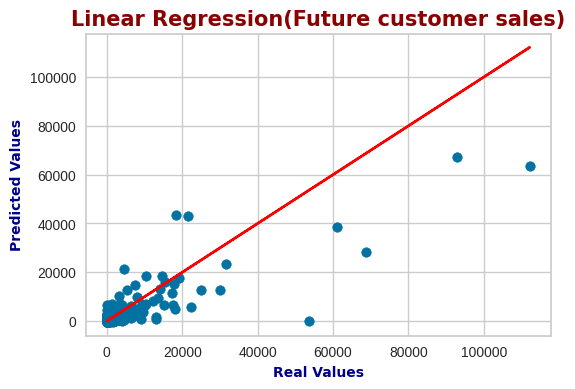

In [79]:
# Visualization of preidcted and real values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_pred_l)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Linear Regression(Future customer sales)", fontdict=baslik_font)
plt.show()

### Random Forest

In [80]:
# Random Forest

# Fitting random forest model to preddict future purchases
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(random_state=0)
clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test) #prediction of target attribute

In [81]:
print('RMSE: ', mean_squared_error(y_test, y_pred_rf)**(1/2))
print('SMAPE', smape(y_test, y_pred_rf))
print('R2: ', r2_score(y_test, y_pred_rf))

RMSE:  2780.3793173992103
SMAPE 103.02983151895862
R2:  0.6300913455634887


In [82]:
# storing results in a dataframe
RF_results = pd.DataFrame({'algorithm':['Random Forest'],
            'MSE': [ mean_squared_error(y_test, y_pred_rf)],
            'MAE': [mean_absolute_error(y_test, y_pred_rf)],
            'r2_score': [r2_score(y_test, y_pred_rf)],})
RF_results

,algorithm,MSE,MAE,r2_score
0,Random Forest,7.730509e+06,811.181543,0.630091


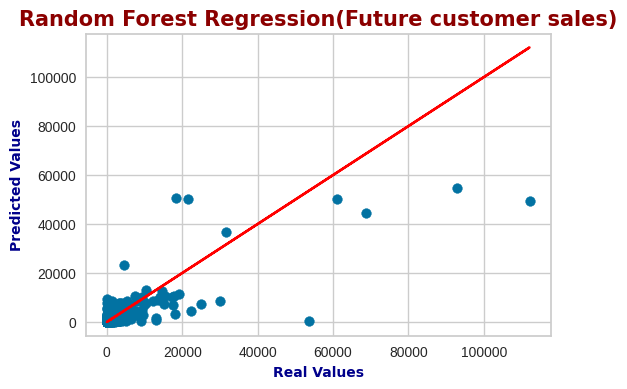

In [83]:
# Visualization of preidcted and real values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_pred_rf)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Random Forest Regression(Future customer sales)", fontdict=baslik_font)
plt.show()

### GradientBoosting (Without Hyperparameters)

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test) #prediction of target attribute

In [85]:
print('RMSE: ', mean_squared_error(y_test, y_pred_gbr)**(1/2))
print('SMAPE', smape(y_test, y_pred_gbr))
print('R2: ', r2_score(y_test, y_pred_gbr))

RMSE:  2822.9972885500515
SMAPE 101.95599018097555
R2:  0.618664431073656


In [86]:
# storing results in a dataframe
GB_results = pd.DataFrame({'algorithm':['Gradient Boosting'],
            'MSE': [ mean_squared_error(y_test, y_pred_gbr)],
            'MAE': [mean_absolute_error(y_test, y_pred_gbr)],
            'r2_score': [r2_score(y_test, y_pred_gbr)],})
GB_results

,algorithm,MSE,MAE,r2_score
0,Gradient Boosting,7.969314e+06,846.565474,0.618664


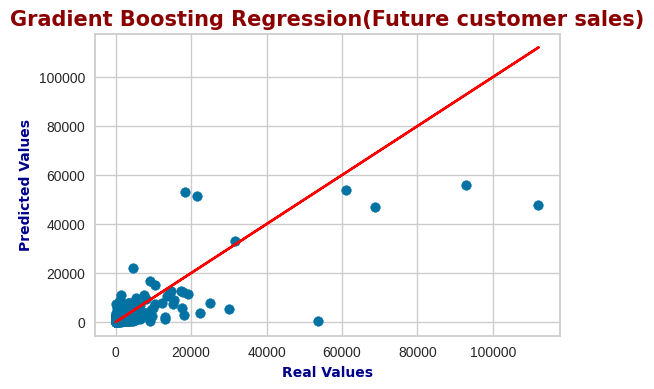

In [87]:
# Visualization of preidcted and real values
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_pred_gbr)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=eksen_font)
plt.ylabel("Predicted Values", fontdict=eksen_font)
plt.title("Gradient Boosting Regression(Future customer sales)", fontdict=baslik_font)
plt.show()

### GradientBoosting (With Hyperparameters)

In [88]:
#Using Hyper-parameters
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(criterion='mse',learning_rate=0.1, n_estimators=60,min_samples_split=5,max_depth=10, random_state=10)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test) #prediction of target attribute

In [89]:
print('RMSE: ', mean_squared_error(y_test, y_pred_gb)**(1/2))
print('SMAPE', smape(y_test, y_pred_gb))
print('R2: ', r2_score(y_test, y_pred_gb))

RMSE:  2663.31159379211
SMAPE 106.04022935000329
R2:  0.6605855302063092


In [90]:
#XGB
from xgboost.sklearn import XGBRegressor
xgb_model = XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

[08:59:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [91]:
print('RMSE: ', mean_squared_error(y_test, y_pred_xgb)**(1/2))
print('SMAPE', smape(y_test, y_pred_xgb))
print('R2: ', r2_score(y_test, y_pred_xgb))

RMSE:  2785.7768818715276
SMAPE 120.33475742599595
R2:  0.6286537404071153


# Dataframe creation for comparison of the model results

In [92]:
pd.concat([Gamma_Gamma, Bg,DNN_results, LR_results, RF_results, GB_results], axis=0, ignore_index=True)

,algorithm,MSE,MAE,r2_score
0,Gamma-Gamma,1.885671e+06,300.581000,0.571462
1,BG/NBD,1.298552e+00,0.663510,0.519980
2,Deep Neural Network,5.946769e+06,747.707546,0.715444
3,Linear Regression,6.494512e+06,760.047057,0.689234
4,Random Forest,7.730509e+06,811.181543,0.630091
5,Gradient Boosting,7.969314e+06,846.565474,0.618664


## Customer Segmentation using clustering ML algorithms

In [93]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [94]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level
Customer ID,,,,,,,,
12346.0,325,1,310.44,1,1,1,3,Low
12347.0,2,182,4310.00,3,3,3,9,High
12348.0,75,31,1770.78,2,2,3,7,Medium
12349.0,18,73,1491.72,3,3,3,9,High
12350.0,310,17,331.46,1,1,1,3,Low
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,1,1,1,3,Low
18281.0,180,7,80.82,1,1,1,3,Low
18282.0,7,12,178.05,3,1,1,5,Low


In [95]:
# Rescaling the attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4263, 3)

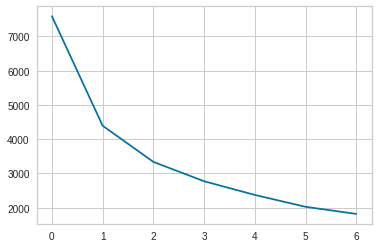

In [96]:
#Elbow Curve to get the right number of Clusters
from sklearn.cluster import KMeans
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [97]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5454333739719732
For n_clusters=3, the silhouette score is 0.5100079766393208
For n_clusters=4, the silhouette score is 0.4787020164931113
For n_clusters=5, the silhouette score is 0.4684336094766369
For n_clusters=6, the silhouette score is 0.41759324009134347
For n_clusters=7, the silhouette score is 0.41617055646406564
For n_clusters=8, the silhouette score is 0.40631306934521033


In [98]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [99]:
 kmeans.labels_

array([2, 1, 0, ..., 0, 1, 0], dtype=int32)

In [100]:
rfm['Kmeans_Cluster'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level,Kmeans_Cluster
Customer ID,,,,,,,,,
12346.0,325,1,310.44,1,1,1,3,Low,2
12347.0,2,182,4310.00,3,3,3,9,High,1
12348.0,75,31,1770.78,2,2,3,7,Medium,0
12349.0,18,73,1491.72,3,3,3,9,High,0
12350.0,310,17,331.46,1,1,1,3,Low,2


In [101]:
# Implementation of k-means clustering method with 3 clusters


rfm_s=rfm.groupby('Kmeans_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetary': ['mean', 'count']})


rfm_s.rename(columns = {'mean' : 'Mean','count' : 'Count'},
               inplace = True)



display(rfm_s.style.background_gradient(cmap='summer_r')) # Display the mean of created clusters with respect to RFM values

In [102]:
# Naming the cluster groups according to the weightage
rfm['Kmeans_Cluster']=rfm['Kmeans_Cluster'].map({0: 'K_Low', 1: 'K_Medium',2:'K_High'})
rfm.sample(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level,Kmeans_Cluster
Customer ID,,,,,,,,,
17460.0,94,29,622.43,1,2,2,5,Low,K_Low
15507.0,171,45,475.86,1,2,2,5,Low,K_High
14021.0,155,22,631.90,1,1,2,4,Low,K_High
18149.0,50,16,612.08,2,1,2,5,Low,K_Low
16401.0,1,186,4098.32,3,3,3,9,High,K_Medium
14881.0,19,17,255.40,3,1,1,5,Low,K_Low
14665.0,60,90,1835.70,2,3,3,8,High,K_Low
16793.0,57,16,243.84,2,1,1,4,Low,K_Low
17173.0,5,86,3766.60,3,3,3,9,High,K_Low


In [103]:
 

 # Comparision of both RFM groups and k-mean cluster groups

rfm = rfm.reset_index()

rfm_melted = pd.melt(frame= rfm, id_vars= ['Customer ID', 'Robust RFM Level','Kmeans_Cluster'], var_name = 'Metrics', value_name = 'Value')

rfm_melted.head()

,Customer ID,Robust RFM Level,Kmeans_Cluster,Metrics,Value
0,12346.0,Low,K_High,Recency,325.0
1,12347.0,High,K_Medium,Recency,2.0
2,12348.0,Medium,K_Low,Recency,75.0
3,12349.0,High,K_Low,Recency,18.0
4,12350.0,Low,K_High,Recency,310.0


## Evaluation of Clustering

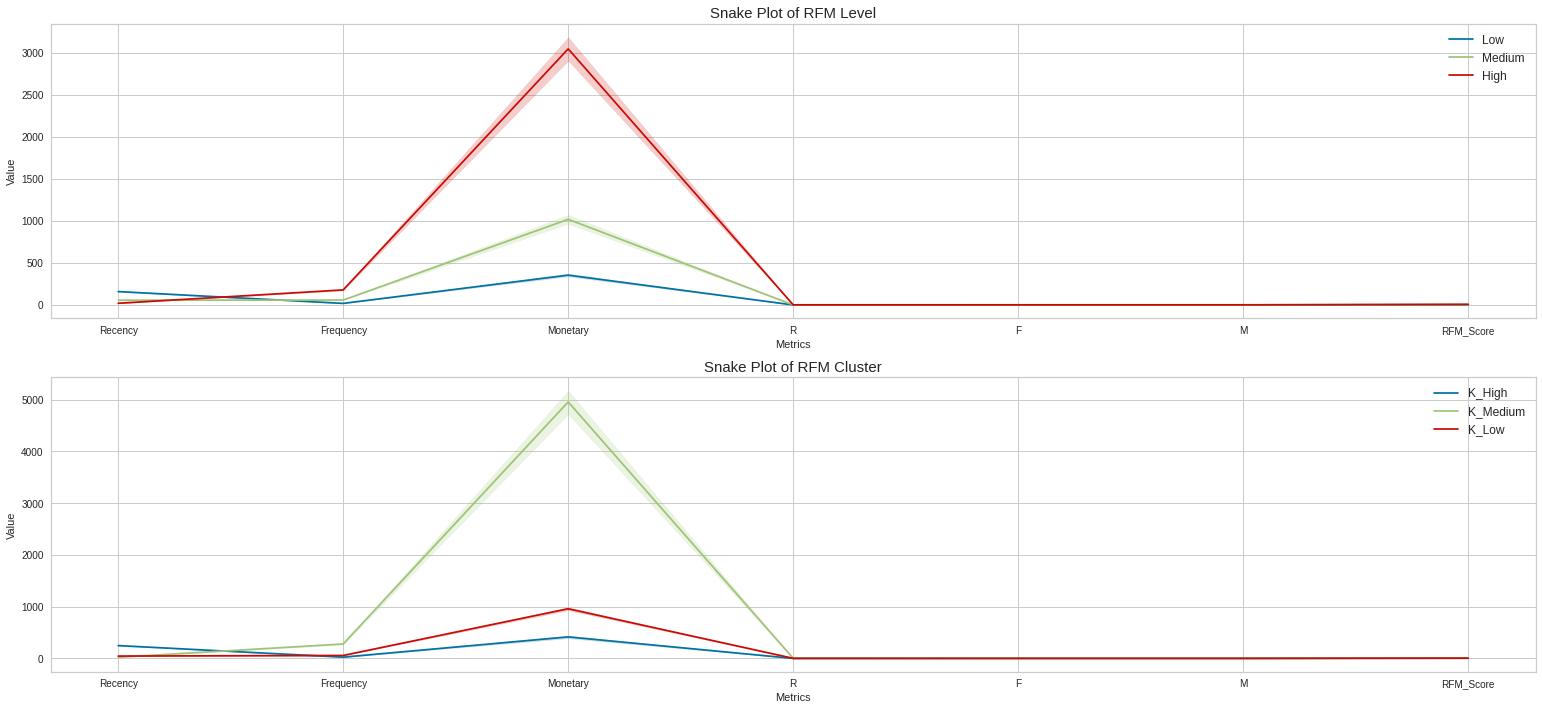

In [104]:
# Snake plot to see the comparision between cluster groups
fig, ax = plt.subplots(nrows=2, figsize=(15,8))
plt.subplots_adjust(right=1.5, top=1.25)


sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Robust RFM Level', data = rfm_melted, ax=ax[0])
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Kmeans_Cluster', data = rfm_melted, ax=ax[1])

ax[0].set_title('Snake Plot of RFM Level', size=15)
ax[1].set_title('Snake Plot of RFM Cluster', size=15)
ax[0].legend(loc='upper right', prop={'size': 12})
ax[1].legend(loc='upper right', prop={'size': 12})

plt.show()

In [105]:
# Caculation of mean to compare RFM groups and k-means cluster groups
total_avg = rfm.iloc[:, 1:4].mean()

cluster_avg = rfm.groupby('Robust RFM Level').mean().iloc[:, 1:4]
prop_rfm = cluster_avg/total_avg - 1

cluster_avg_K = rfm.groupby('Kmeans_Cluster').mean().iloc[:, 1:4]
prop_rfm_K = cluster_avg_K/total_avg - 1

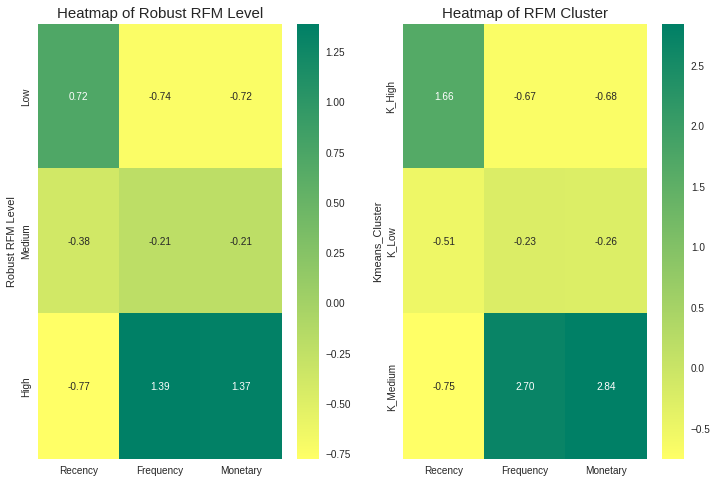

In [106]:
# Comparision of heatmap generated using mean values from both segmentation groups
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
sns.heatmap(prop_rfm, cmap= 'summer_r', fmt= '.2f', annot = True, ax=ax[0])
sns.heatmap(prop_rfm_K, cmap= 'summer_r', fmt= '.2f', annot = True, ax=ax[1])

ax[0].set_title('Heatmap of Robust RFM Level', size=15)
ax[1].set_title('Heatmap of RFM Cluster', size=15)

plt.show()

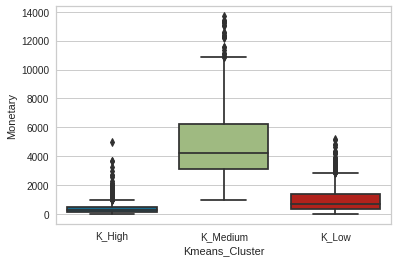

In [107]:
sns.boxplot(x='Kmeans_Cluster', y='Monetary', data=rfm)

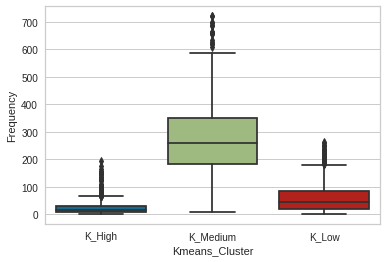

In [108]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Kmeans_Cluster', y='Frequency', data=rfm)

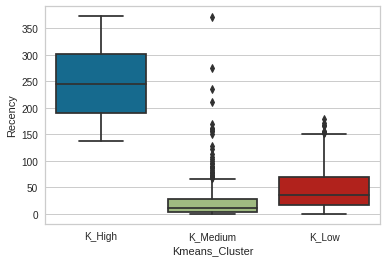

In [109]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Kmeans_Cluster', y='Recency', data=rfm)

## Hierarchical Clustering

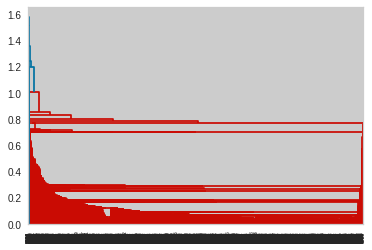

In [110]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

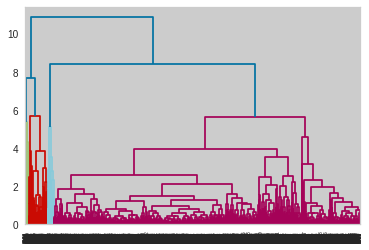

In [111]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

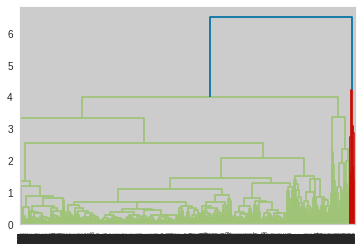

In [112]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [113]:
# Cutting the Dendrogram based on K (3 clusters)

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [114]:
# Assign cluster labels

rfm['H_Cluster'] = cluster_labels
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level,Kmeans_Cluster,H_Cluster
0,12346.0,325,1,310.44,1,1,1,3,Low,K_High,0
1,12347.0,2,182,4310.00,3,3,3,9,High,K_Medium,0
2,12348.0,75,31,1770.78,2,2,3,7,Medium,K_Low,0
3,12349.0,18,73,1491.72,3,3,3,9,High,K_Low,0
4,12350.0,310,17,331.46,1,1,1,3,Low,K_High,0


In [115]:
# Implementation of k-means clustering method with 3 clusters


rfm_h=rfm.groupby('H_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetary': ['mean', 'count']})


rfm_h.rename(columns = {'mean' : 'Mean','count' : 'Count'},
               inplace = True)



display(rfm_h.style.background_gradient(cmap='summer_r')) # Display the mean of created clusters with respect to RFM values

In [116]:
# Naming the cluster groups according to the weightage
rfm['H_Cluster']=rfm['H_Cluster'].map({0: 'H_Low', 1: 'H_Medium',2:'H_High'})
rfm.sample(10)

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Robust RFM Level,Kmeans_Cluster,H_Cluster
570,13115.0,11,120,2289.000,3,3,3,9,High,K_Low,H_Low
1708,14715.0,24,71,867.380,3,2,2,7,Medium,K_Low,H_Low
978,13685.0,2,39,1934.305,3,2,3,8,High,K_Low,H_Low
4025,17956.0,249,1,12.750,1,1,1,3,Low,K_High,H_Low
855,13507.0,3,162,2479.160,3,3,3,9,High,K_Low,H_Low
806,13447.0,23,59,1129.140,3,2,2,7,Medium,K_Low,H_Low
1591,14547.0,3,355,3974.750,3,3,3,9,High,K_Medium,H_Low
3216,16808.0,99,23,288.420,1,1,1,3,Low,K_Low,H_Low
1622,14591.0,15,176,1320.210,3,3,3,9,High,K_Low,H_Low
3516,17236.0,12,105,916.130,3,3,2,8,High,K_Low,H_Low


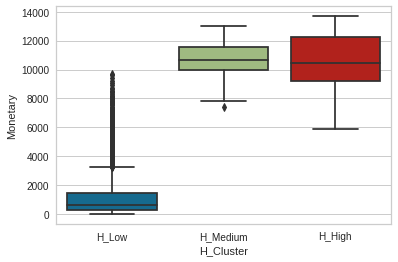

In [117]:
# Plot Cluster Id vs Monetary

sns.boxplot(x='H_Cluster', y='Monetary', data=rfm)

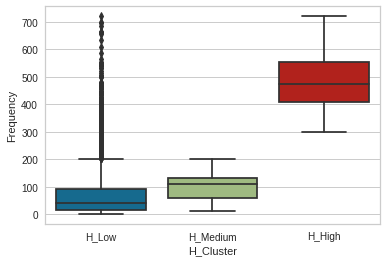

In [118]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='H_Cluster', y='Frequency', data=rfm)

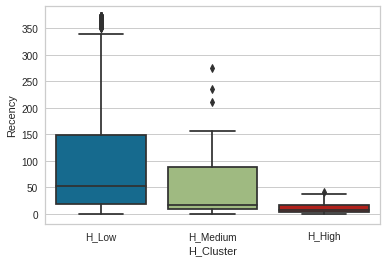

In [119]:
# Plot Cluster Id vs Recency

sns.boxplot(x='H_Cluster', y='Recency', data=rfm)